In [ ]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [1]:
#use the Q2 2016 data first
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return(idx)

In [3]:
#ercot 2017 loads

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")

testloads = np.array(list(ercot2017['ERCOT']))

In [4]:
startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

allhours = []

while curr < enddate:
    allhours.append(curr)
    curr += datetime.timedelta(hours=1)
    
trainhours = np.array(allhours[0:-8760]) #all but last year, not a leap year
testhours = np.array(allhours[-8760:])

#get indecies of day starts in testhours
startdate = datetime.datetime(year=2017, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

day_start_i = []
i = 0

while curr < enddate:
    if curr.hour == 0:
        day_start_i.append(i)
    curr += datetime.timedelta(hours=1)
    i += 1


570.2781314827672 36556.57900951147


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


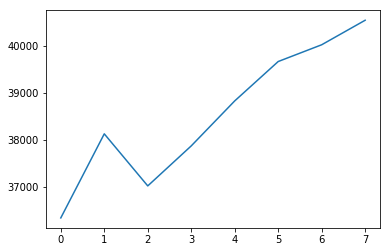

In [6]:
#ERCOT data
lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #dropping leap days so years line up

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]
training = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT'])]
means = [ np.nanmean(y) for y in training ]

#use system-wide loadgrowth for all regions
A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
a, b = np.linalg.lstsq(A, np.array(means))[0]
print(a, b)
projected_mean = a*7.0 + b
plt.plot(means + [projected_mean])
means.append(projected_mean)
load_growth = np.array(means)

yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT']) - load_growth[i]
    
    
#need to calculate cdf per month    
model = np.nanmean(yearly_loads[0:6,:], axis=0)
test = yearly_loads[7,:]
#plt.plot(model, color="blue", label="model")
#plt.plot(test, color="red", label="test data")
#plt.legend()
#plt.show()

In [34]:
np.nanmax(yearly_loads[0:10,:])

31066.880542458108

In [9]:
dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for j in range(len(dayspermonth)):
    hstart = 0 
    for k in range(j):
        hstart += dayspermonth[k]*24
    hend = hstart + dayspermonth[j]*24
    
    print(hstart, hend)

dayspermonth = [31, 28, 31, 30, 31, 30, 31, 30, 31, 30, 31]

0 744
744 1416
1416 2160
2160 2880
2880 3624
3624 4344
4344 5088
5088 5832
5832 6552
6552 7296
7296 8016
8016 8760


In [ ]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return(idx)

In [41]:
power_vals = np.arange(np.min(model),np.max(model),0.5)
monthly_power_vals = {}
monthly_average_power_vals = {}
true_cdf = {}
empirical_cdf = {}
avg_model_ranks = []#np.zeros((yearly_loads.shape[1], 1))
emp_model_ranks = []
test_ranks = []#np.zeros((yearly_loads.shape[1], 1))

true_monthly_max = {}
true_monthly_min = {}
model_monthly_max = {}
model_monthly_min = {}

for j in range(len(dayspermonth)):
    true_cdf[j] = []
    empirical_cdf[j] = []
    #for each month
    hstart = 0 
    for k in range(j):
        hstart += dayspermonth[k]*24
    hend = hstart + dayspermonth[j]*24
    
    #support over expected monthly maxes and mins
    monthly_average_power_vals[j] = np.arange(np.min(model[hstart:hend,]),np.max(model[hstart:hend,]),0.5)
    
    #support over empirical monthly maxes and mins
    model_monthly_max[j] = np.nanmax(yearly_loads[0:6,hstart:hend])
    model_monthly_min[j] = np.nanmin(yearly_loads[0:6,hstart:hend])
    
    true_monthly_max[j] = np.nanmax(test[hstart:hend,])
    true_monthly_min[j] = np.nanmin(test[hstart:hend,])
    
    monthly_power_vals[j] = np.arange(model_monthly_min[j],model_monthly_max[j],0.5)
    
    #calculate monthly empirical cdf based on hourly average model
    for p in monthly_power_vals[j]:
        greater = np.sum([ 1 for k in model[hstart:hend,] if k >= p ])/float(dayspermonth[j]*24)
        empirical_cdf[j].append(1.0 - greater)
    
    #calculate true cdf values for each hour of 2017
    for p in monthly_power_vals[j]:
        greater = np.sum([ 1 for k in test[hstart:hend,] if k >= p ])/float(dayspermonth[j]*24)
        true_cdf[j].append(1.0 - greater)
    
    for i in range(hstart,hend+1):
        val = test[i,]
        idx_avg = find_nearest_idx(monthly_average_power_vals[j], val)
        mod_avg = empirical_cdf[j][idx_avg]
        avg_model_ranks.append(mod_avg)
        
        idx_emp = find_nearest_idx(monthly_power_vals[j], val)
        mod = empirical_cdf[j][idx_emp]
        emp_model_ranks.append(mod)
        
        idx_true = find_nearest_idx(np.arange(true_monthly_min[j],true_monthly_max[j],0.5), val)
        true = true_cdf[j][idx_true]
        test_ranks.append(true)
    


IndexError: list index out of range

In [39]:
true_monthly_max[j]

19087.541757309154

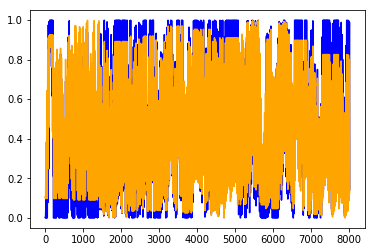

In [32]:
plt.plot(avg_model_ranks, color="blue")
plt.plot(test_ranks, color="orange")`

In [ ]:
plt.plot(emp_model_ranks, color="green")
plt.plot(test_ranks, color="orange")

In [23]:
for i in range(len(dayspermonth)):
    print(np.min(monthly_power_vals[i]))

-11314.84803221206
-12564.756294378507
-13599.229487878947
-13487.68809354506
-12269.684188045076
-7750.695326878896
-6071.793923046102
-4434.797038379357
-9532.04401821297
-13133.649019878578
-13452.556273044494


In [26]:
model.shape

(8760,)

In [ ]:
#compare perfect load forecast
#using neural network
#perfect and no action bars
#cdf or load forecasting
#time budget for load shedding